In [3]:
# Test Fastpitch checkpoints trained on OpenSLR > German Neutral TTS Dataset with pre-trained hifigan vocoder

In [19]:
# imports
from nemo.collections.tts.models import FastPitchModel
from nemo.collections.tts.models import HifiGanModel
import IPython.display as ipd
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
import torch
import numpy as np

In [22]:
fastpitch_path="/NeMo/nemo_experiments/FastPitch/2022-05-02_06-09-14/checkpoints/FastPitch--v_loss=0.6676-epoch=184.ckpt"
hfg_ngc="tts_hifigan"
outputdir="/NeMo/nemo_experiments/FastPitch/"
data_path="/data/openslr-95-german-neutral-tts/thorsten-de/wavs/"
seed=100

In [5]:
!pwd

/NeMo


In [24]:
#test
test1 = "Man darf sich nicht von anderen entmutigen lassen."
test1_id = "2edfc39c95ef247c6e39c929d122f4cc"
#val
test2 = "Allergiker sollten einen Staubsauger mit Filter nehmen."
test2_id = "34c7692223011b6153e27ae82ec1a7ae"

In [7]:
# load models
spec_gen_model = FastPitchModel.load_from_checkpoint(checkpoint_path=fastpitch_path).eval().cuda()
vocoder_model = HifiGanModel.from_pretrained(hfg_ngc, strict=False).eval().cuda()

[NeMo I 2022-05-02 15:38:35 tokenize_and_classify:87] Creating ClassifyFst grammars. This might take some time...


[NeMo W 2022-05-02 15:39:02 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.TTSDataset
      manifest_filepath: /data/openslr-95-german-neutral-tts/thorsten-de/train_manifest.json
      sample_rate: 22050
      sup_data_path: /data/openslr-95-german-neutral-tts/thorsten-de/sup_data
      sup_data_types:
      - align_prior_matrix
      - pitch
      n_fft: 1024
      win_length: 1024
      hop_length: 256
      window: hann
      n_mels: 80
      lowfreq: 0
      highfreq: 8000
      max_duration: null
      min_duration: 0.1
      ignore_file: null
      trim: false
      pitch_fmin: 65.40639132514966
      pitch_fmax: 2093.004522404789
      pitch_norm: true
      pitch_mean: 132.5526885986328
      pitch_std: 37.61381912231445
    dataloader_params:
      drop_last: false

[NeMo I 2022-05-02 15:39:02 features:259] PADDING: 1
[NeMo I 2022-05-02 15:39:02 features:276] STFT using torch
[NeMo I 2022-05-02 15:39:06 cloud:66] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/tts_hifigan/versions/1.0.0rc1/files/tts_hifigan.nemo to /root/.cache/torch/NeMo/NeMo_1.9.0rc0/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo
100% [......................................................................] 315386678 / 315386678[NeMo I 2022-05-02 15:39:18 common:747] Instantiating model from pre-trained checkpoint


[NeMo W 2022-05-02 15:39:23 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.MelAudioDataset
      manifest_filepath: /home/fkreuk/data/train_finetune.txt
      min_duration: 0.75
      n_segments: 8192
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 64
      num_workers: 4
    
[NeMo W 2022-05-02 15:39:23 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.MelAudioDataset
      manifest_filepath: /home/fkreuk/data/val_finetune.txt
      min_duration: 3
      n_segments: 66150


[NeMo I 2022-05-02 15:39:23 features:259] PADDING: 0
[NeMo I 2022-05-02 15:39:23 features:276] STFT using torch


[NeMo W 2022-05-02 15:39:23 features:233] Using torch_stft is deprecated and has been removed. The values have been forcibly set to False for FilterbankFeatures and AudioToMelSpectrogramPreprocessor. Please set exact_pad to True as needed.


[NeMo I 2022-05-02 15:39:23 features:259] PADDING: 0
[NeMo I 2022-05-02 15:39:23 features:276] STFT using torch
[NeMo I 2022-05-02 15:39:25 save_restore_connector:209] Model HifiGanModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.9.0rc0/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo.


In [32]:
# run inference

with torch.no_grad():
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = False
    parsed = spec_gen_model.parse(str_input=test1, normalize=True)
    spectrogram = spec_gen_model.generate_spectrogram(tokens=parsed)
    print(spectrogram.size()) # debug
#     audio = vocoder_model.convert_spectrogram_to_audio(spec=spectrogram, sigma=0.8, denoise=True)
    audio = vocoder_model.convert_spectrogram_to_audio(spec=spectrogram)

spectrogram = spectrogram.to('cpu').numpy()[0]
audio = audio.to('cpu').numpy()[0]
audio = audio / np.abs(audio).max()

torch.Size([1, 80, 269])


In [33]:
# generated audio
ipd.Audio(audio, rate=22050)

In [34]:
# original audio
ipd.Audio(data_path+test1_id+'.wav', rate=22050)

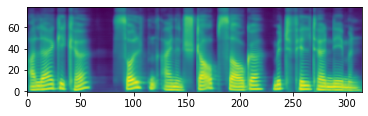

In [20]:
%matplotlib inline

# visualize the spectrogram

if spectrogram is not None:
    imshow(spectrogram, origin="lower")
    plt.show()